In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, tilt_distance_LI, compute_tilt_data, bearing


In [2]:
# sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
# with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies_sample.pkl', 'rb') as f:
#     dic_sample = pickle.load(f)
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")

df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [4]:
df_sample = df_eddies[df_eddies.Eddy.isin(sample_eddies)]
df_sample.TiltDis.min(), df_sample.TiltDis.max(), df_sample.TiltDis.mean()


(np.float64(0.3190352011999737),
 np.float64(74.83647909480015),
 np.float64(13.306062035989259))

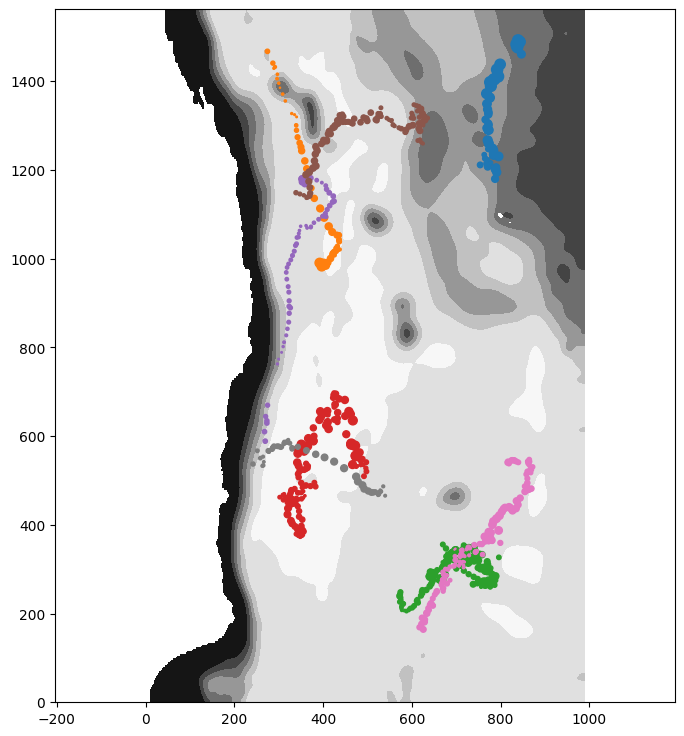

In [5]:
plt.figure(figsize=(8,9))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')

for eddy in sample_eddies:

    df = df_eddies[df_eddies.Eddy==eddy]
    plt.scatter(df.xc, df.yc, s=df.TiltDis)
plt.axis('equal'); 
plt.show()
    

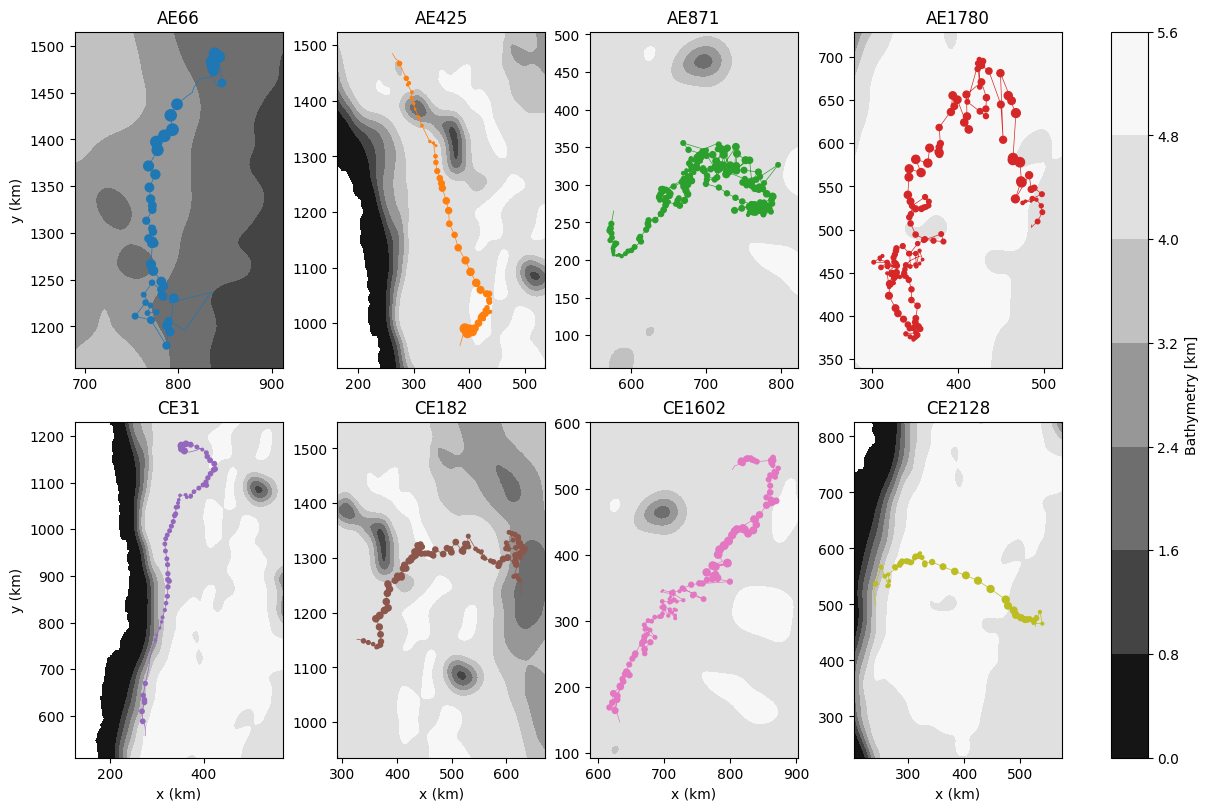

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12,8), constrained_layout=True)
mappable = None
for e, eddy in enumerate(sample_eddies):
    ax = axs[e//4, e%4]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')
    if mappable is None:
        mappable = m
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(df.xc, df.yc, lw=.5, color=colors[e])
    ax.scatter(df.xc, df.yc, s=df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==eddy].Cyc.iloc[0]
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df.xc.min(), df.xc.max()); ax.set_ylim(df.yc.min(), df.yc.max())

    if e // 4 == 1:
        ax.set_xlabel('x (km)')
    if e % 4 == 0:
        ax.set_ylabel('y (km)')

# shared colourbar on the far right
cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), location='right')
cbar.set_label('Bathymetry [km]')


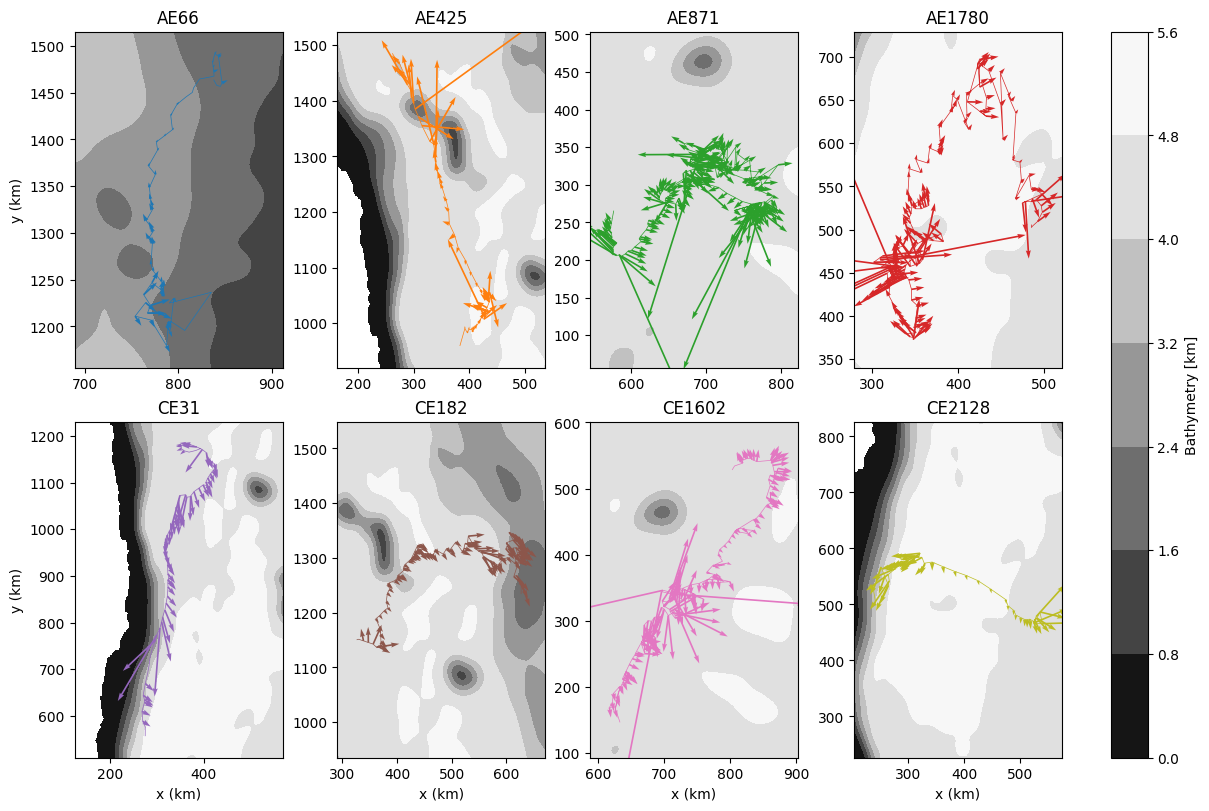

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(12,8), constrained_layout=True)
mappable = None
for e, eddy in enumerate(sample_eddies):
    ax = axs[e//4, e%4]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')
    if mappable is None:
        mappable = m
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(df.xc, df.yc, lw=.5, color=colors[e])

    theta = np.deg2rad(df.TiltDir.to_numpy())  # bearing from north, clockwise
    u = np.sin(theta)                          # x-component
    v = np.cos(theta)                          # y-component

    ax.quiver(df.xc, df.yc, u, v, color=colors[e],
               angles='xy', scale_units='xy', scale=.005*df.TiltDis.to_numpy(), width=0.008)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].Cyc.iloc[0]
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df.xc.min(), df.xc.max()); ax.set_ylim(df.yc.min(), df.yc.max())

    if e // 4 == 1:
        ax.set_xlabel('x (km)')
    if e % 4 == 0:
        ax.set_ylabel('y (km)')

# shared colourbar on the far right
cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), location='right')
cbar.set_label('Bathymetry [km]')

# plt.tight_layout()


In [8]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        if len(df):
            df2 = df.copy()
            cols = df2.columns.drop("Depth")
            # df2[cols] = df2[cols].sub(df2[cols].iloc[0])
    
            tmp = (df2[['x','y']] if not df2.empty else pd.DataFrame(index=[], columns=['x','y']))
            tmp = tmp.reindex(range(n))                     # pads with NaNs
            tmp.columns = [f'{eddy}_x_{d}', f'{eddy}_y_{d}']
            frames.append(tmp)

df_depths_orig = pd.concat([base, *frames], axis=1, copy=False)
df_depths_orig


,Depth,Eddy66_x_0,Eddy66_y_0,Eddy66_x_1,Eddy66_y_1,Eddy66_x_2,Eddy66_y_2,Eddy66_x_3,Eddy66_y_3,Eddy66_x_4,...,Eddy2128_x_52,Eddy2128_y_52,Eddy2128_x_53,Eddy2128_y_53,Eddy2128_x_54,Eddy2128_y_54,Eddy2128_x_55,Eddy2128_y_55,Eddy2128_x_56,Eddy2128_y_56
0,1.783320,838.082945,1463.359042,841.944207,1458.453989,845.647270,1457.132245,843.828657,1451.758555,846.783970,...,253.084486,567.480090,241.881085,536.699813,238.604963,523.279677,240.586005,517.400123,242.627058,498.439709
1,5.879627,838.449025,1462.889245,842.548504,1458.370782,846.492748,1457.401894,851.858869,1460.250166,847.620948,...,247.609623,560.154560,240.715586,532.490102,238.290099,522.534501,239.280399,516.258631,243.434436,499.768934
2,10.725783,838.490020,1462.700349,842.953076,1458.517750,846.865130,1457.608137,849.458620,1462.528121,NaN,...,246.281557,545.042801,240.745331,532.123683,238.367262,522.731495,239.246365,516.226479,243.800521,500.998354
3,16.383097,838.643865,1462.945791,843.346376,1458.755273,847.123878,1457.839066,849.376952,1463.139390,NaN,...,243.799958,535.565244,240.616023,531.272790,238.396574,522.900646,239.201841,516.231714,243.843124,502.265386
4,22.925581,838.758631,1462.524487,843.581149,1458.630220,847.346424,1458.110049,849.559308,1462.686655,NaN,...,243.910670,532.647053,240.598377,530.937821,238.286392,522.686191,239.195147,516.253579,243.571661,503.336370
5,30.444118,838.899192,1462.704843,843.973783,1459.065805,848.195131,1460.480151,849.703698,1463.492525,NaN,...,243.769833,530.865328,240.644250,530.863947,238.164996,522.375225,239.006638,516.161120,243.011629,503.642985
6,39.052712,839.117184,1462.531297,844.352940,1459.700432,848.259160,1462.114486,849.823990,1463.332039,NaN,...,243.670698,529.715716,240.596766,530.618297,238.173968,522.198867,238.825620,516.215450,242.030140,503.900624
7,48.897638,839.480305,1462.474008,844.380259,1461.188048,848.335503,1462.858759,849.919529,1464.681550,NaN,...,243.619169,529.028098,240.506829,530.299263,238.209823,522.420784,238.481207,516.020812,241.513391,503.474732
8,60.170639,840.037014,1462.728148,844.866533,1462.552153,848.400615,1465.279241,849.194135,1470.838220,NaN,...,243.535369,528.354243,240.444449,530.076358,238.148097,522.564441,238.168532,515.534681,241.119982,502.661505
9,73.127842,841.301853,1463.629237,845.664766,1464.587517,848.068300,1469.311099,846.416749,1480.745980,NaN,...,243.429020,527.584898,240.481575,530.022219,237.992685,522.612111,238.053530,515.256108,240.797998,502.139416


### Eddy propogation


In [9]:
import re
import pandas as pd
from collections import defaultdict

df_pos = df_depths_orig.copy()

pat = re.compile(r'(Eddy\d+)_([xy])_(\d+)')

# Parse info
info = []
for c in df_pos.columns:
    m = pat.fullmatch(c)
    if m:
        eddy, comp, day = m.groups()
        info.append((eddy, comp, int(day), c))

cols_by_eddy = defaultdict(lambda: defaultdict(dict))
for eddy, comp, day, col in info:
    cols_by_eddy[eddy][day][comp] = col

# --- Collect diff columns here ---
td_frames = []   # each entry is a small DataFrame

for eddy, days in cols_by_eddy.items():
    day_nums = sorted(days.keys())

    for i in range(1, len(day_nums)):
        d_prev = day_nums[i-1]
        d_now  = day_nums[i]

        if 'x' not in days[d_prev] or 'y' not in days[d_prev]:
            continue
        if 'x' not in days[d_now] or 'y' not in days[d_now]:
            continue

        x0 = df_pos[days[d_prev]['x']]
        y0 = df_pos[days[d_prev]['y']]
        x1 = df_pos[days[d_now]['x']]
        y1 = df_pos[days[d_now]['y']]

        td = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        colname = f'{eddy}_diff_{d_now}'
        td_frames.append(td.rename(colname).to_frame())

# --- FINAL CONCAT (fast, no fragmentation) ---
out = pd.concat([df_pos[['Depth']], *td_frames], axis=1)
out


,Depth,Eddy66_diff_1,Eddy66_diff_2,Eddy66_diff_3,Eddy66_diff_4,Eddy66_diff_5,Eddy66_diff_6,Eddy66_diff_7,Eddy66_diff_8,Eddy66_diff_9,...,Eddy2128_diff_46,Eddy2128_diff_47,Eddy2128_diff_48,Eddy2128_diff_49,Eddy2128_diff_50,Eddy2128_diff_52,Eddy2128_diff_53,Eddy2128_diff_54,Eddy2128_diff_55,Eddy2128_diff_56
0,1.783320,6.242506,3.931880,5.673085,28.142845,9.121463,5.917076,9.298149,5.289021,6.906035,...,13.571722,17.070070,11.952916,9.659387,2.123970,35.854924,32.755787,13.814233,6.204328,19.069956
1,5.879627,6.101003,4.061503,6.075188,20.262655,8.621856,4.732460,8.630399,3.003144,5.577244,...,10.440322,13.240073,9.674331,9.776290,1.023175,27.295152,28.510524,10.246804,6.353522,17.004885
2,10.725783,6.116618,4.016412,5.561694,NaN,NaN,4.157451,8.380161,2.426586,4.968940,...,8.693297,11.322444,8.312739,9.982172,1.374642,15.697423,14.055369,9.688572,6.564149,15.894531
3,16.383097,6.298734,3.887024,5.759321,NaN,NaN,3.804659,7.377996,2.715670,4.729355,...,7.717808,9.912781,7.337409,10.505984,1.957157,16.029485,5.344399,8.661336,6.717373,14.717331
4,22.925581,6.198548,3.801036,5.083520,NaN,NaN,3.439282,6.925486,2.337487,4.514427,...,7.284626,8.671253,6.809144,10.259692,3.270522,16.131250,3.727298,8.569404,6.496487,13.638481
5,30.444118,6.244522,4.451983,3.369002,NaN,NaN,3.430482,7.829878,2.316158,4.407333,...,6.916307,7.639582,7.126145,10.178938,3.708714,16.601241,3.125583,8.843365,6.270842,13.143199
6,39.052712,5.952053,4.591972,1.982707,NaN,NaN,3.090524,7.462088,2.395633,4.663355,...,6.429508,7.274055,8.190795,9.256964,3.838952,16.979790,3.203702,8.761093,6.018799,12.724932
7,48.897638,5.065890,4.293626,2.414892,NaN,NaN,2.543450,5.313633,2.639048,4.159343,...,5.964970,7.025765,8.883415,8.576306,4.193126,17.008602,3.361922,8.206502,6.405723,12.907295
8,60.170639,4.832724,4.463939,5.615329,NaN,NaN,2.530317,6.019585,2.449341,4.094318,...,6.324509,6.844650,9.269581,8.286353,4.544962,17.058422,3.538286,7.855070,7.029790,13.207185
9,73.127842,4.466914,5.299924,11.553534,NaN,NaN,1.425467,4.302340,2.073030,3.577903,...,6.210532,6.706423,9.486694,8.212955,4.919240,17.208437,3.824652,7.816922,7.356255,13.400736


In [10]:
df_eddy = out.filter(like="Eddy871").copy()
# df_eddy.insert(0, 'Depth', out.Depth)
df_eddy


,Eddy871_diff_1,Eddy871_diff_2,Eddy871_diff_3,Eddy871_diff_4,Eddy871_diff_5,Eddy871_diff_6,Eddy871_diff_7,Eddy871_diff_8,Eddy871_diff_9,Eddy871_diff_10,...,Eddy871_diff_220,Eddy871_diff_221,Eddy871_diff_222,Eddy871_diff_223,Eddy871_diff_224,Eddy871_diff_225,Eddy871_diff_226,Eddy871_diff_227,Eddy871_diff_228,Eddy871_diff_229
0,3.086974,4.441803,13.621349,10.779587,1.276259,2.650210,4.457298,5.987908,4.180778,7.432452,...,27.840615,10.241924,5.101169,12.229749,36.424598,31.649518,6.823814,9.392027,25.096541,17.994206
1,2.142523,5.936724,12.286208,10.054289,2.488659,3.511006,4.429069,6.666134,3.746327,5.176988,...,20.326379,9.162650,6.705993,12.718120,21.625975,34.771933,14.737882,11.320656,18.511733,14.240080
2,1.365852,6.388499,11.805792,9.665836,2.940897,4.100488,4.589364,6.704407,4.008708,3.954106,...,14.237572,7.369497,7.590437,17.102884,7.252568,21.033295,5.753606,20.179194,15.655046,13.739436
3,1.059584,7.044644,11.489913,9.402549,3.010615,4.668782,4.783600,6.598596,4.318032,3.367794,...,10.196717,3.455844,15.467989,12.342626,7.802398,18.637787,7.760749,18.677746,12.836034,10.983543
4,0.760879,7.281422,11.118610,9.161793,3.241828,4.876544,5.159840,6.513920,4.216864,3.104202,...,8.966625,4.091327,15.486103,11.002014,8.949269,17.876041,4.470399,8.430833,4.863889,8.894552
5,0.467810,7.480706,10.844758,8.797314,3.588288,5.082603,5.395192,6.221532,4.487502,2.855813,...,9.178187,4.190277,8.949687,7.408544,8.651846,9.830553,3.447049,4.863827,5.610066,8.940439
6,1.075711,7.834726,9.885829,8.466836,3.940500,5.181235,5.591906,6.225250,4.529719,2.616395,...,8.663851,2.623289,4.972738,5.297189,7.494375,6.717234,3.631924,2.414548,5.246143,7.399415
7,2.354928,8.731038,7.993103,8.086970,4.257006,5.192754,5.733120,6.036149,4.704239,2.431095,...,5.612074,2.431461,2.593177,4.702154,4.523930,6.056752,3.330366,1.377104,4.181833,6.728905
8,4.566275,8.916436,6.514772,7.233527,4.824172,5.077765,5.712173,5.865342,4.910356,2.607169,...,3.615886,1.840457,1.008776,3.514121,3.737798,4.286203,2.225380,2.416894,5.062205,4.807707
9,5.205096,7.825646,6.214228,5.724554,6.373244,4.478732,5.063502,6.287203,4.670834,2.185051,...,2.854206,1.808545,1.130231,2.831986,3.020532,3.245215,2.459902,3.280382,6.038120,3.821241


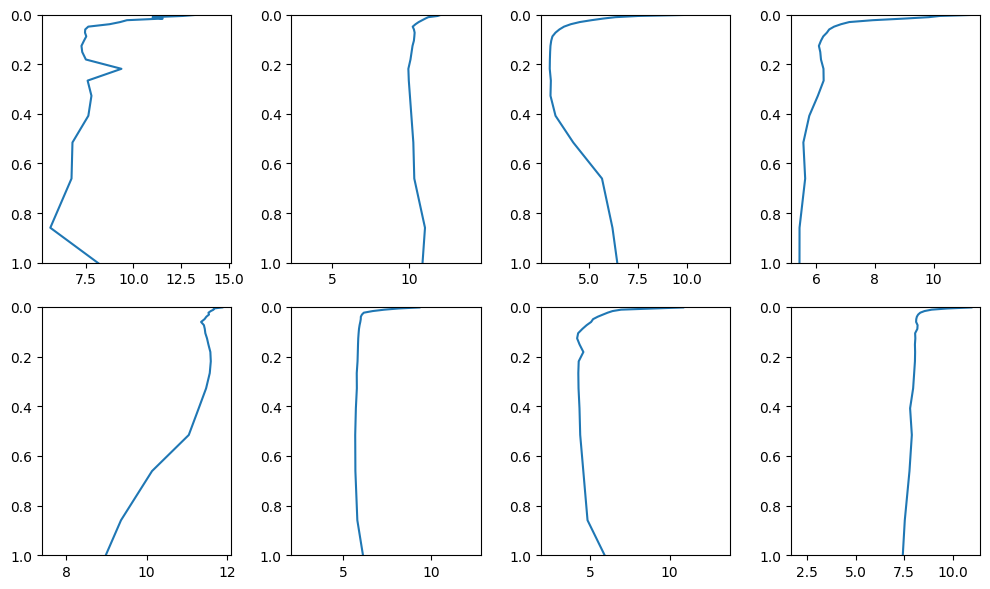

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))
for e, eddy in enumerate(sample_eddies):

    df_eddy = out.filter(like=f"Eddy{eddy}").copy()

    ax = axs[e // 4, e % 4]
    
    ax.plot(df_eddy.mean(axis=1), out.Depth/1e3)
    ax.invert_yaxis(); ax.set_ylim(1, 0)
plt.tight_layout()


### Extract TD

In [12]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        if len(df):
            df2 = df.copy()
            cols = df2.columns.drop("Depth")
            df2[cols] = df2[cols].sub(df2[cols].iloc[0])
    
            tmp = (df2[['x','y']] if not df2.empty else pd.DataFrame(index=[], columns=['x','y']))
            tmp = tmp.reindex(range(n))                     # pads with NaNs
            tmp.columns = [f'{eddy}_x_{d}', f'{eddy}_y_{d}']
            frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


,Depth,Eddy66_x_0,Eddy66_y_0,Eddy66_x_1,Eddy66_y_1,Eddy66_x_2,Eddy66_y_2,Eddy66_x_3,Eddy66_y_3,Eddy66_x_4,...,Eddy2128_x_52,Eddy2128_y_52,Eddy2128_x_53,Eddy2128_y_53,Eddy2128_x_54,Eddy2128_y_54,Eddy2128_x_55,Eddy2128_y_55,Eddy2128_x_56,Eddy2128_y_56
0,1.783320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.879627,0.36608,-0.469797,0.604297,-0.083208,0.845479,0.269648,8.030212,8.491611,0.836977,...,-5.474863,-7.325529,-1.165499,-4.209711,-0.314864,-0.745176,-1.305606,-1.141492,0.807379,1.329225
2,10.725783,0.407074,-0.658693,1.008869,0.063761,1.21786,0.475892,5.629963,10.769566,NaN,...,-6.802928,-22.437289,-1.135753,-4.57613,-0.237701,-0.548182,-1.33964,-1.173644,1.173463,2.558645
3,16.383097,0.56092,-0.413251,1.402169,0.301284,1.476608,0.706821,5.548295,11.380835,NaN,...,-9.284528,-31.914846,-1.265061,-5.427023,-0.208389,-0.379031,-1.384164,-1.168409,1.216066,3.825677
4,22.925581,0.675685,-0.834556,1.636942,0.176231,1.699155,0.977804,5.73065,10.9281,NaN,...,-9.173816,-34.833037,-1.282707,-5.761992,-0.318572,-0.593486,-1.390858,-1.146544,0.944603,4.896661
5,30.444118,0.816247,-0.654199,2.029575,0.611816,2.547861,3.347905,5.87504,11.73397,NaN,...,-9.314653,-36.614762,-1.236835,-5.835866,-0.439967,-0.904452,-1.579367,-1.239003,0.384571,5.203276
6,39.052712,1.034239,-0.827745,2.408733,1.246443,2.61189,4.982241,5.995332,11.573484,NaN,...,-9.413788,-37.764374,-1.284318,-6.081516,-0.430995,-1.08081,-1.760385,-1.184673,-0.596918,5.460915
7,48.897638,1.39736,-0.885034,2.436052,2.734058,2.688233,5.726514,6.090872,12.922994,NaN,...,-9.465317,-38.451992,-1.374256,-6.40055,-0.39514,-0.858893,-2.104798,-1.379311,-1.113667,5.035023
8,60.170639,1.954069,-0.630895,2.922325,4.098163,2.753345,8.146996,5.365477,19.079665,NaN,...,-9.549117,-39.125847,-1.436635,-6.623455,-0.456866,-0.715236,-2.417473,-1.865442,-1.507075,4.221796
9,73.127842,3.218907,0.270195,3.720559,6.133528,2.42103,12.178853,2.588091,28.987425,NaN,...,-9.655466,-39.895192,-1.399509,-6.677594,-0.612278,-0.667566,-2.532475,-2.144015,-1.82906,3.699707


In [13]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        tmp = (df[['TD']] if not df.empty else pd.DataFrame(index=[], columns=['TD']))
        tmp = tmp.reindex(range(n))                     # pads with NaNs
        tmp.columns = [f'{eddy}_{d}']
        frames.append(tmp)
df_depths_TD = pd.concat([base, *frames], axis=1, copy=False)
df_depths_TD


,Depth,Eddy66_0,Eddy66_1,Eddy66_2,Eddy66_3,Eddy66_4,Eddy66_5,Eddy66_6,Eddy66_7,Eddy66_8,...,Eddy2128_47,Eddy2128_48,Eddy2128_49,Eddy2128_50,Eddy2128_51,Eddy2128_52,Eddy2128_53,Eddy2128_54,Eddy2128_55,Eddy2128_56
0,1.783320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.879627,0.595587,0.609998,0.887437,11.687248,0.895668,0.558271,1.923610,2.525449,0.813649,...,1.705146,2.773097,3.407353,4.457174,NaN,9.145354,4.368072,0.808967,1.734246,1.555217
2,10.725783,0.774329,1.010881,1.307538,12.152368,NaN,0.841918,2.962373,4.305580,1.171885,...,2.579791,4.346501,5.232590,6.577881,NaN,23.445933,4.714966,0.597500,1.781032,2.814903
3,16.383097,0.696712,1.434172,1.637061,12.661240,NaN,1.082665,3.739314,4.602314,1.404957,...,3.244232,5.681487,6.357279,8.036661,NaN,33.237928,5.572518,0.432540,1.811377,4.014302
4,22.925581,1.073794,1.646401,1.960415,12.339518,NaN,1.411566,4.561419,5.119526,1.907882,...,3.807857,6.755305,6.952575,9.052396,NaN,36.020818,5.903041,0.673582,1.802512,4.986939
5,30.444118,1.046057,2.119786,4.207145,13.122582,NaN,1.646882,4.345403,5.968408,2.074614,...,4.297784,7.663287,7.507847,9.923579,NaN,37.780995,5.965492,1.005786,2.007368,5.217468
6,39.052712,1.324693,2.712124,5.625362,13.034168,NaN,1.844281,4.980971,6.326690,2.217266,...,4.394558,7.448691,7.920714,10.362933,NaN,38.920012,6.215650,1.163575,2.121888,5.493442
7,48.897638,1.654056,3.661888,6.326102,14.286445,NaN,2.022858,6.653524,6.020544,2.166461,...,4.379046,7.087094,8.193852,10.961226,NaN,39.599847,6.546420,0.945428,2.516480,5.156715
8,60.170639,2.053390,5.033381,8.599678,19.819737,NaN,2.409790,6.880386,6.917752,2.289005,...,4.399852,6.998592,8.358361,11.474563,NaN,40.274278,6.777468,0.848698,3.053531,4.482727
9,73.127842,3.230227,7.173752,12.417160,29.102732,NaN,4.044185,8.739984,6.560825,2.426779,...,4.418925,6.877978,8.354940,11.844934,NaN,41.046978,6.822675,0.905830,3.318167,4.127141


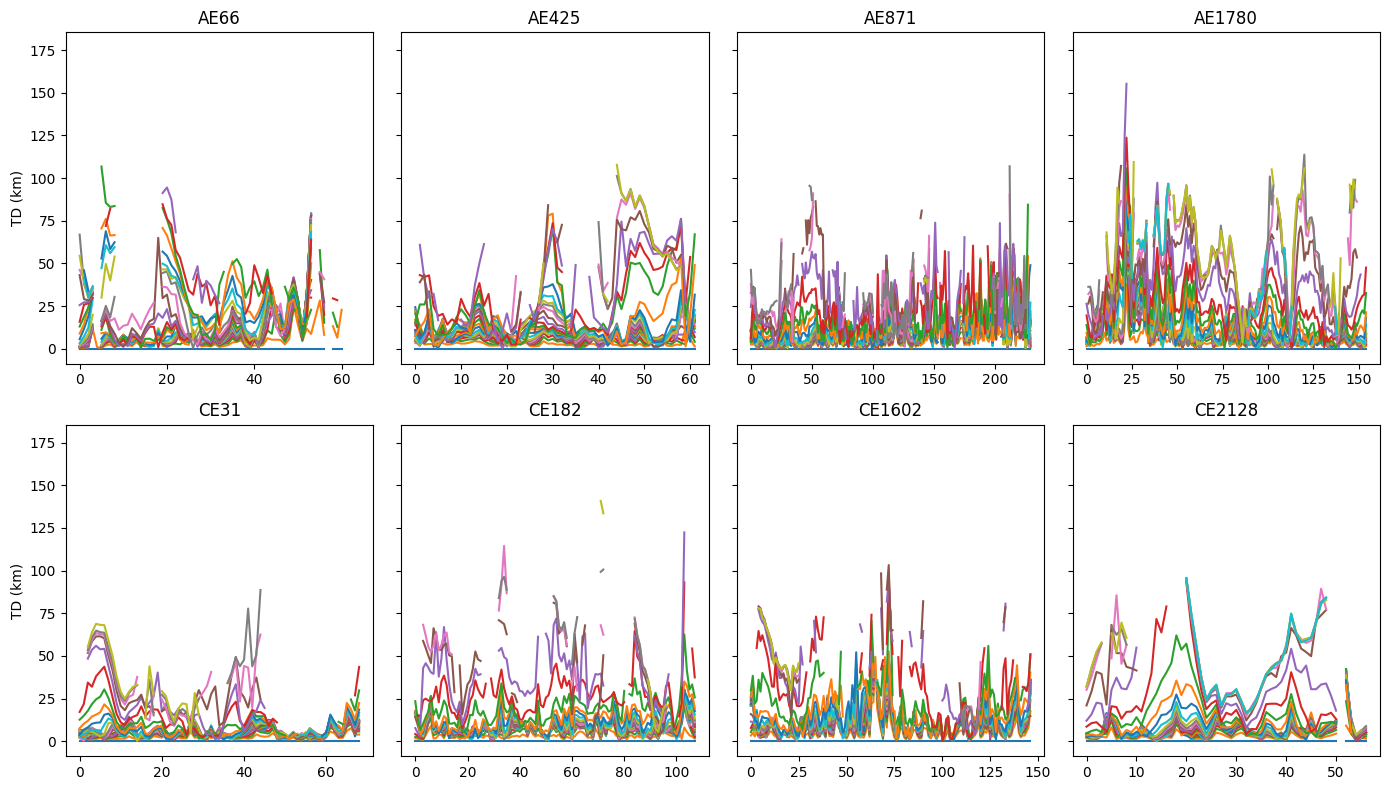

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    # df_sub = df.loc[:, df.columns.str.contains(f"Eddy{eddy}") | (df.columns == "Depth")]
    df_sub = df_depths_TD.loc[:, df_depths_TD.columns.str.contains(f'Eddy{eddy}')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('TD (km)')
axs[1,0].set_ylabel('TD (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()


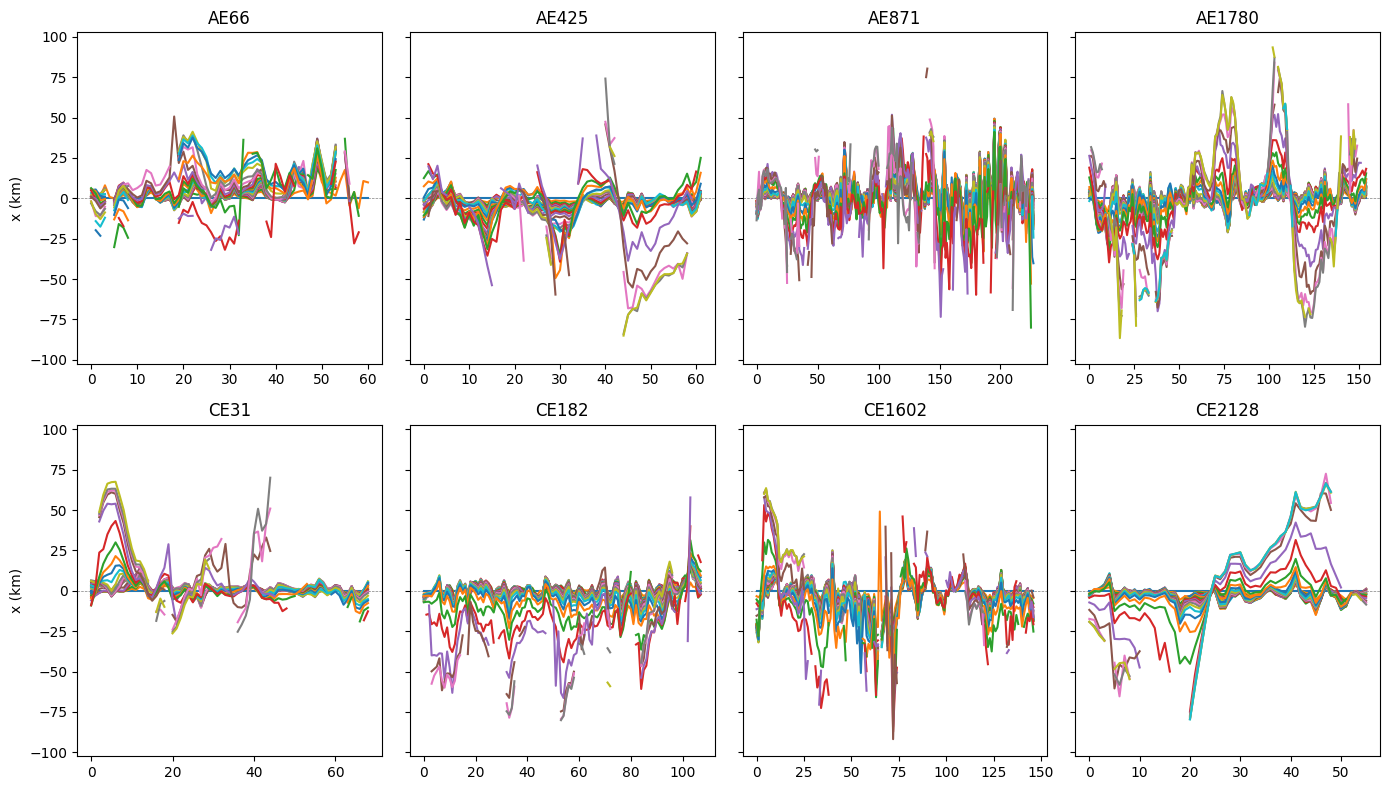

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_x')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('x (km)')
axs[1,0].set_ylabel('x (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()

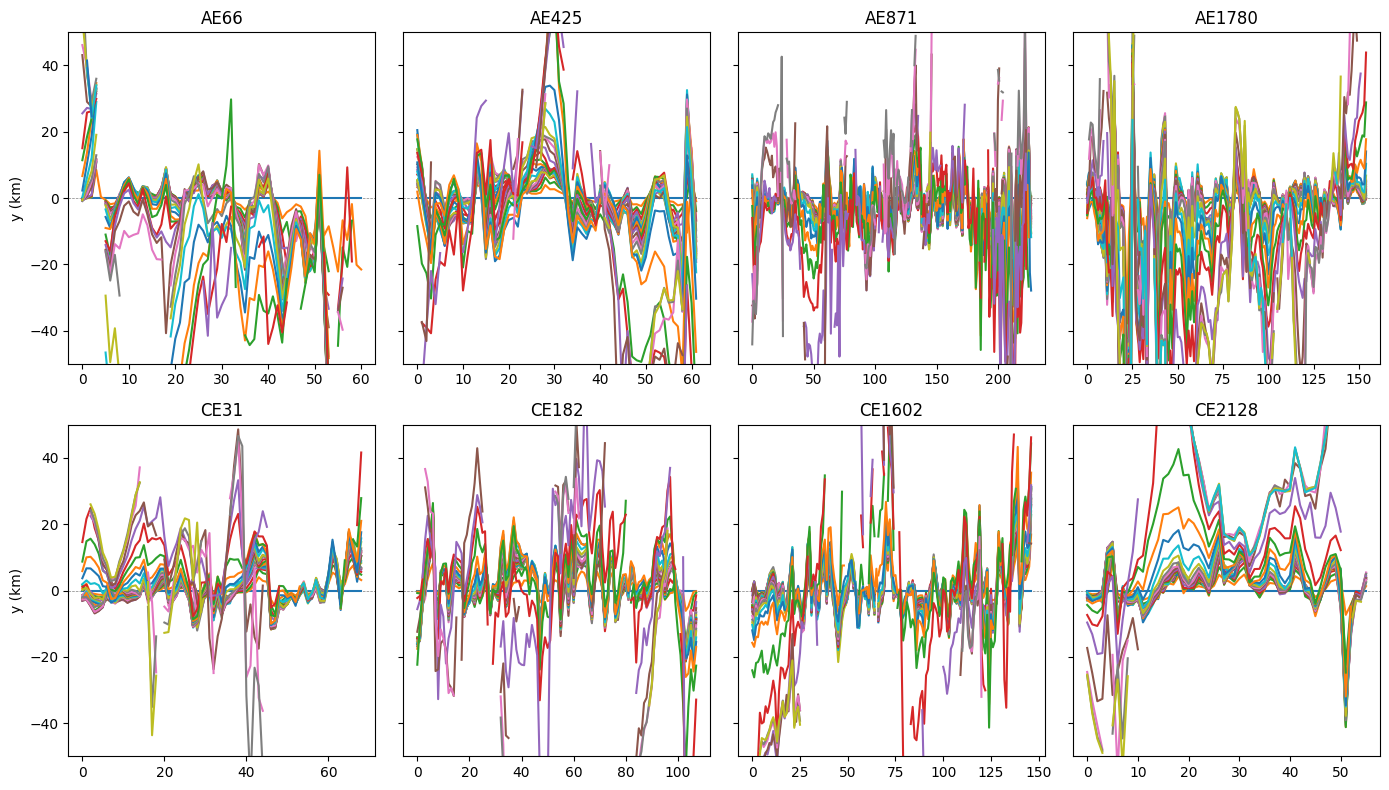

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_y')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
axs[0,0].set_ylabel('y (km)')
axs[1,0].set_ylabel('y (km)')
axs[0,0].set_ylim(-50, 50)
# axs[0,1].legend(ncol=2)
plt.tight_layout()


### Li Tilt

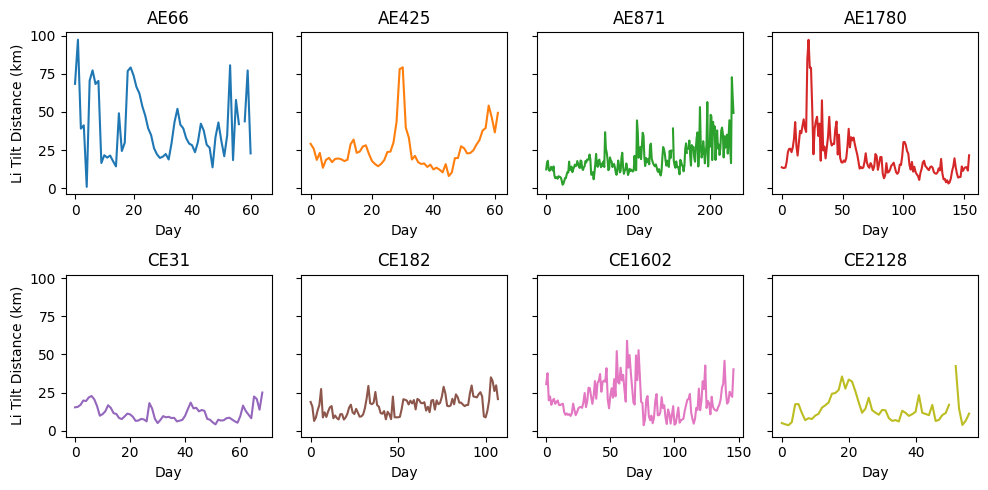

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day].copy()
        if len(df):
            df = df[df.Depth.abs() < 1000]
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Li Tilt Distance (km)')
axs[1,0].set_ylabel('Li Tilt Distance (km)')
plt.tight_layout()


### Regs Tilt

In [18]:
# for e, eddy in enumerate(sample_eddies):
#     dic = dic_sample[f'Eddy{eddy}']
#     df = compute_tilt_data(dic, eddy)
#     if e == 0:
#         df_tilt_data = df
#     else:
#         df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
# df_eddies = df_eddies.merge(
#     df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
#     how='left',
#     left_on=['Eddy', 'Day'],
#     right_on=['Eddy', 'Day']
# )

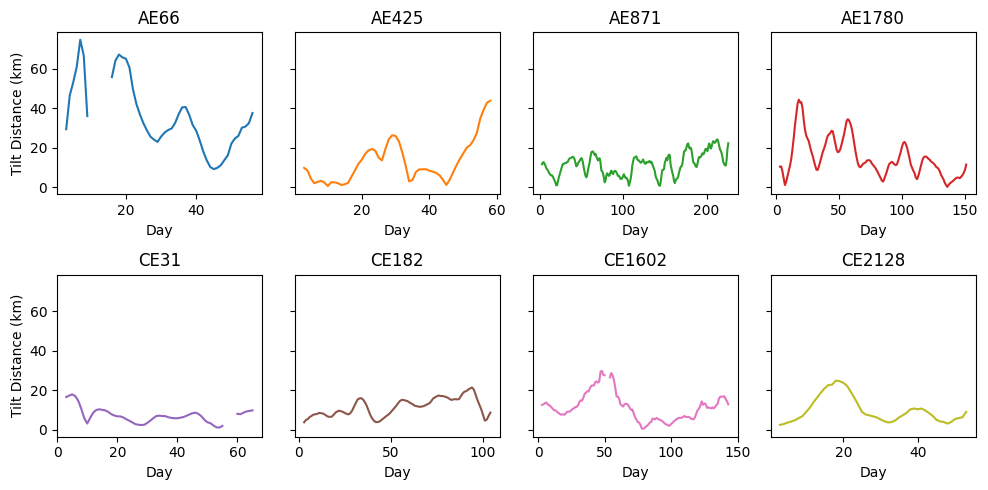

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')
plt.tight_layout()


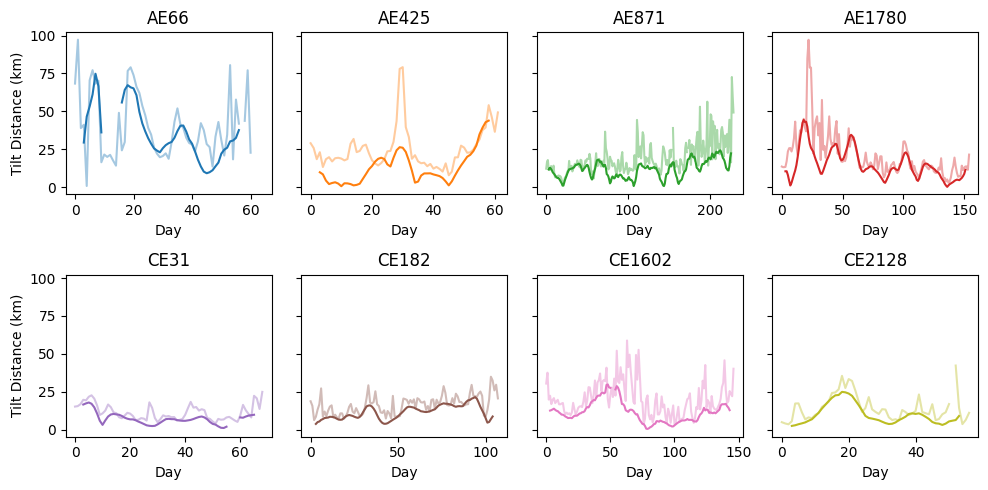

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day].copy()
        if len(df):
            df = df[df.Depth.abs() < 1000]
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10], alpha=.4)
    df = df_eddies[df_eddies.Eddy==int(eddy[4:])]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
    # ax.axhline(y=10, color='r')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')

plt.tight_layout()


#### My Tilt Breakdown

In [21]:
from mpl_toolkits.mplot3d import Axes3D 

# Create a 2x4 grid of 3D subplots
fig = plt.figure(figsize=(20, 10))  # make it wide and tall enough
axes = []

ref_days = [50, 40, 52, 20, 
            20, 30, 20, 20]
azims = [0, 90, 90, 0,
         25, 25, 25, 25]

for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    dic = dic_sample[f'Eddy{eddy}']
    num = num
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        ax = fig.add_subplot(2, 4, e+1, projection='3d')
        axes.append(ax)

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            ax.plot(xt, yt, y, alpha=.9, lw=.5, color=colors[e])
            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                ax.plot(xmu, ymu, d, color=colors[e], lw=2)
        
                theta = np.linspace(0, 2*np.pi, 100)
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)
                    ax.plot(cx, cy, cz, lw=2, color=colors[e])
        
                ax.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)
        
        ax.invert_zaxis()
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_zlabel('Depth (km)')
        
        ax.view_init(elev=5, azim=azims[e])
        ax.set_title(f'Tilt Dist. {round(tilt_dist)}')
    
plt.tight_layout()
plt.show()


NameError: name 'num' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)

ref_days = [52, 50, 40, 20, 
            20, 30, 20, 20]
for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    
    dic = dic_sample[f'Eddy{eddy}']
    num = num
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        # PLOT

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            
            ax0.plot(xt, y, alpha=.9, lw=.5, color=colors[e])
            ax1.plot(yt, y, alpha=.9, lw=.5, color=colors[e])

            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                theta = np.linspace(0, 2*np.pi, 100)
                cx_mins, cx_maxs, cy_mins, cy_maxs = [], [], [], []
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)

                    cx_mins.append(cx.min())
                    cx_maxs.append(cx.max())
                    cy_mins.append(cy.min())
                    cy_maxs.append(cy.max())
                    
                    # ax0.plot(cx, cz, lw=2, color=colors[e])
                    # ax1.plot(cy, cz, lw=2, color=colors[e])
                ax0.fill_betweenx(d, cx_mins, cx_maxs, color=colors[e], alpha=0.6)
                ax1.fill_betweenx(d, cy_mins, cy_maxs, color=colors[e], alpha=0.6)

                ax0.plot(xmu, d, color=colors[e], lw=2)
                ax1.plot(ymu, d, color=colors[e], lw=2)

                ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='k', ls='--', lw=2)
                ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)

        ax0.set_xlabel('x (km)')
        ax1.set_xlabel('y (km)')
        ax0.set_ylabel('Depth (km)')

        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        ax0.set_title(f'{cyc}{eddy}, Day {ref_day}')
        ax1.set_title(f'{cyc}{eddy}, Day {ref_day}')

        # ax0.set_xlim(-50, 50)
        # ax1.set_xlim(-50, 50)

axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.sin(theta_rad)
    dy = r * np.cos(theta_rad)
    return a[0] - dx, a[1] - dy

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig, axs = plt.subplots(1, 2, figsize=(13,6.5))
cf0 = axs[0].contourf(X_grid, Y_grid, h/1e3, cmap='gray')
cf1 = axs[1].contourf(X_grid, Y_grid, h/1e3, cmap='gray')
# Add horizontal colorbars at the top
fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')
fig.colorbar(cf1, ax=axs[1], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

axs[0].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['saddlebrown'], alpha=.9)
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['saddlebrown'], alpha=.9)

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy==eddy]
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)
    axs[1].plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)
    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day==day]
        tilt_dis = data.iloc[0]['TiltDis']
        tilt_dir = data.iloc[0]['TiltDir']
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc   # FIXED
        xb, yb = point_b([x0, y0], tilt_dis, (tilt_dir-20) % 360)
        axs[0].plot([x0, xb], [y0, yb], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        axs[1].plot([x0, xb], [y0, yb], color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            axs[0].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3, facecolors='none')
            axs[1].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3, facecolors='none')
        else:
            axs[0].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3)
            axs[1].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3)

c1 = axs[0].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                      colors='k', linewidths=.5)
axs[0].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = axs[0].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                      colors='k', linewidths=.5)
axs[0].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

c1 = axs[1].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                      colors='k', linewidths=.5)
axs[1].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = axs[1].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                      colors='k', linewidths=.5)
axs[1].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

axs[0].axis('equal')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
axs[0].set_xlim(X_grid.min(), X_grid.max())
axs[0].set_ylim(800, Y_grid.max())

axs[1].axis('equal')
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('y (km)')
axs[1].legend(loc='lower left')
axs[1].set_xlim(X_grid.min(), X_grid.max())
axs[1].set_ylim(0, 800)

plt.tight_layout()


In [ ]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.sin(theta_rad)
    dy = r * np.cos(theta_rad)
    return a[0] - dx, a[1] - dy

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig, axs = plt.subplots(2, 4, figsize=(13,6.5), constrained_layout=True)

# Add horizontal colorbars at the top
# fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

gap = 10
mappable = None
s = 5
for e, eddy in enumerate(sample_eddies):
    ax = axs[e//4, e%4]
    df = df_eddies[df_eddies.Eddy==eddy]
    m = ax.contourf(X_grid, Y_grid, h/1e3, cmap='gray')
    if mappable is None:
        mappable = m
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)
    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day==day]
        tilt_dis = data.iloc[0].TiltDis
        tilt_dir = data.iloc[0].TiltDir
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc   # FIXED
        xb, yb = point_b([x0, y0], tilt_dis, (tilt_dir-20) % 360)
        ax.plot([x0, xb], [y0, yb], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        ax.plot([x0, xb], [y0, yb], color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=s, zorder=3, facecolors='none')
        else:
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=s, zorder=3)

    # c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
    #                       colors='k', linewidths=.5)
    # ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    # c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
    #                       colors='k', linewidths=.5)
    # ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    if e // 4 == 1:
        ax.set_xlabel('x (km)')
    if e % 4 == 0:
        ax.set_ylabel('y (km)')
    ax.set_xlim(df_eddy.xc.min()-gap, df_eddy.xc.max()+gap)
    ax.set_ylim(df_eddy.yc.min()-gap, df_eddy.yc.max()+gap)

cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), location='right')
cbar.set_label('Bathymetry [km]')

# plt.tight_layout()


In [ ]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.sin(theta_rad)
    dy = r * np.cos(theta_rad)
    return a[0] - dx, a[1] - dy

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig = plt.figure(figsize=(13, 13), constrained_layout=True)
gs = fig.add_gridspec(6, 3)

gap = 5
mappable = None
s = 5

# slots for all non-special eddies on a 6x3 grid (left two columns)
# roughly mimics a 3x2 layout: rows 0,2,4
normal_slots = [
    (0, 0), (2, 0), (4, 0),
    (0, 1), (2, 1), (4, 1),
]

k = 0
axes_list = []
for e, eddy in enumerate(sample_eddies):

    # eddy 1 and 4 get tall panels in the right column
    if e == 1:
        ax = fig.add_subplot(gs[0:3, 2])   # top-right, 1.5 "rows" tall
        axes_list.append(ax)
        col = 2
        row = 0
        is_tall = True
        ax.set_ylabel('y (km)')
    elif e == 4:
        ax = fig.add_subplot(gs[3:6, 2])   # bottom-right, 1.5 "rows" tall
        axes_list.append(ax)
        col = 2
        row = 4
        is_tall = True
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    else:
        row, col = normal_slots[k]
        k += 1
        ax = fig.add_subplot(gs[row:row+2, col])
        axes_list.append(ax)
        is_tall = False

    df = df_eddies[df_eddies.Eddy == eddy]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='gray')
    if mappable is None:
        mappable = m

    df_eddy = df_eddies[df_eddies.Eddy == eddy]
    ax.plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)

    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day == day]
        tilt_dis = data.iloc[0].TiltDis
        tilt_dir = data.iloc[0].TiltDir

        plot_data = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies['Day'] == int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc
        xb, yb = point_b([x0, y0], tilt_dis, (tilt_dir - 20) % 360)

        ax.plot([x0, xb], [y0, yb], color=colors[e], zorder=2)

        cyc = df_eddies[df_eddies.Eddy == eddy].Cyc.iloc[0]
        if d == 0:
            ax.plot([x0, xb], [y0, yb], color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}')

        if np.isnan(tilt_dis):
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                       s=15, zorder=3, facecolors='none')
        else:
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                       s=s, zorder=3)
    if eddy==1602:
        a, b = -1.5, -1.5
    elif eddy==1780:
        a, b = 1, 0
    elif eddy==182:
        a, b = -1.5, 0
    elif eddy==871:
        a, b = .5, 0
    else:
        a, b = 1, 1
        
    ax.text(df_eddy.iloc[0].xc+a*15, df_eddy.iloc[0].yc+b*15, 'A',
            color='r', fontsize=14)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df_eddy.xc.min() - gap, df_eddy.xc.max() + gap)
    ax.set_ylim(df_eddy.yc.min() - gap, df_eddy.yc.max() + gap)

    # axis labels: left column gets y, bottom band gets x
    if col == 0:
        ax.set_ylabel('y (km)')
    # bottom "row" for small plots (row==4) and the lower tall panel (eddy 4)
    if (not is_tall and row == 4) or (is_tall and e == 4):
        ax.set_xlabel('x (km)')

cbar = fig.colorbar(mappable, ax=axes_list, location='top', shrink=0.4)
cbar.set_label('Bathymetry [km]')



In [ ]:
df_eddies[df_eddies.Eddy==1602]


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(14, 8),
                        subplot_kw={'projection': 'polar'},
                        sharex=True)

axs = axs.flatten()

for e, eddy in enumerate(sample_eddies[:8]):  # limit to 8 eddies
    ax = axs[e]

    df = df_eddies[df_eddies.Eddy == eddy].copy()
    directions = df.TiltDir
    magnitudes = df.TiltDis
    
    # Define bins
    dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
    mag_bins = [0, 10, 20, 30, 40, np.inf]
    
    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1
    
    # Count occurrences per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d, m in zip(dir_idx, mag_idx):
        if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
            counts[m, d] += 1
    
    # Polar bar plot
    n_dirs = len(dir_bins) - 1
    angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
    width = 2 * np.pi / n_dirs
    bottom = np.zeros(n_dirs)
    colors_wr = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))
    
    for i in range(len(mag_bins)-1):
        ax.bar(angles, counts[i], width, bottom=bottom,
               color=colors_wr[i], edgecolor='k',
               label=f'{mag_bins[i]:.0f}-{mag_bins[i+1]:.0f}')
        bottom += counts[i]
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

# Put one legend outside the grid
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.0))

plt.tight_layout()
plt.show()




In [ ]:
# Adjustable bin width
bin_width = 10  # km
max_depth_km = 40  # adjust as needed

# bins = np.arange(0, max_depth_km + bin_width, bin_width)
bins = [ 0, 10, 20, 30, np.inf]
bin_labels = [f"[{b}–{b+bin_width})" for b in bins[:-2]] \
           + [f"[{bins[-2]}–{bins[-1]}]"]

# Prepare DataFrame
eddies = [int(eddy[4:]) for eddy in list(dic_sample.keys())]
cycs = [df_eddies[df_eddies.Eddy==e].iloc[0].Cyc for e in eddies]
eddy_names = [cycs[k] + str(eddies[k]) for k in range(len(eddies))]

bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy == eddy].copy()
    depths = []
    for day in df.Day.unique():
        sub = df[df.Day == day]
        if not sub.empty:
            data = sub.iloc[0]
            depths.append(data.TiltDis)
        else:
            depths.append(np.nan)
    counts, _ = np.histogram(depths, bins=bins)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    bin_counts.loc[:, f'{cyc}{eddy}'] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6),
                edgecolor='black', color=colors)
plt.xlabel('Tilt Bin (km)')
plt.ylabel('Number of Eddy-Days')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy].copy()
    rs = []
    for day in df.Day.unique():
        data = df[df.Day == day].iloc[0]
        r = data.TiltDis
        if not np.isnan(r):
            rs.append(r)
        theta = np.deg2rad(data.TiltDir)  # degrees → radians

        # true north convention
        u = r * np.sin(theta)  # eastward (x)
        v = r * np.cos(theta)  # northward (y)

        ax.quiver(data.xc, data.yc, u, v, angles='xy', scale_units='xy',
                  scale=.5, color=colors[e])

    ax.axis('equal')
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    # ax.set_xlim(-np.nanmax(rs), np.nanmax(rs))
    # ax.set_ylim(-np.nanmax(rs), np.nanmax(rs))

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)
    t = np.arange(len(df))

    # insert NaN when wrap-around occurs
    diff = np.diff(th, prepend=th[0])
    th[np.abs(diff) > 180] = np.nan

    ax.plot(t, th, color=colors[e])
    # ax.plot(t, mag, color=colors[e], ls='--')
    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')

axs[0,0].set_ylabel('Tilt Direction (° True North)')
axs[1,0].set_ylabel('Tilt Direction (° True North)')
plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5),
                        subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = df.TiltDis.to_numpy()
    theta_deg = df.TiltDir.to_numpy()
    phi = np.deg2rad(theta_deg)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.plot(phi, r, color=colors[e])

    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')

plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 4, figsize=(10, 5),
                        subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = df.TiltDis.to_numpy()
    theta_deg = df.TiltDir.to_numpy()
    phi = np.deg2rad(theta_deg)

    # build line segments
    points = np.array([phi, r]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # time = each index is a day
    t = np.arange(len(r))

    lc = LineCollection(segments, cmap='Blues', norm=Normalize(vmin=t.min(), vmax=t.max()))
    lc.set_array(t)
    lc.set_linewidth(2)
    lc.set_alpha(0.9)

    # recolour colormap to match base colour
    base = np.array(colors[e])
    cmap = plt.get_cmap('Blues')
    lc.set_cmap(plt.cm.colors.LinearSegmentedColormap.from_list(
        "", [base*0.4, base]
    ))

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.add_collection(lc)

    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_rlim(0, np.nanmax(r)+5)

plt.tight_layout()
plt.show()


In [ ]:
# break

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = np.deg2rad(df.TiltDir.to_numpy(dtype=float))  # radians for polar plot

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.plot(th, r, color=colors[e])

    # --- tighten the radial axis around the data ---
    ax.set_rlim(r.min(), r.max())

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    m = ~np.isnan(th)
    r_new = np.arange(r.min(), r.max(), 0.001)

    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m.any() and m.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360

    phi = np.deg2rad(th_wrap)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.plot(phi, r_new, color=colors[e])

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    r_new = np.arange(r.min(), r.max(), 0.001)

    # --- angle (unwrap → interp → wrap) ---
    m_th = ~np.isnan(th)
    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m_th.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m_th]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m_th], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360
    phi = np.deg2rad(th_wrap)

    # --- magnitude (linear interp, no extrapolation) ---
    m_mag = ~np.isnan(mag)
    mag_interp = np.full_like(r_new, np.nan, dtype=float)
    if m_mag.sum() > 1:
        mag_interp = np.interp(r_new, r[m_mag], mag[m_mag], left=np.nan, right=np.nan)
        mag_interp = np.maximum(mag_interp, 0)  # keep non-negative

    # plot only where both are finite
    ok = np.isfinite(phi) & np.isfinite(mag_interp)

    # scale marker areas (points^2); tweak k as needed
    k = 1
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.scatter(phi[ok], r_new[ok], s=k * mag_interp[ok], alpha=0.8, color=colors[e], linewidths=0, zorder=3)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    r_new = np.arange(r.min(), r.max(), 0.001)

    # --- angle (unwrap → interp → wrap) ---
    m_th = ~np.isnan(th)
    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m_th.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m_th]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m_th], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360
    phi = np.deg2rad(th_wrap)

    # --- magnitude (linear interp, no extrapolation) ---
    m_mag = ~np.isnan(mag)
    mag_interp = np.full_like(r_new, np.nan, dtype=float)
    if m_mag.sum() > 1:
        mag_interp = np.interp(r_new, r[m_mag], mag[m_mag], left=np.nan, right=np.nan)
        mag_interp = np.maximum(mag_interp, 0)  # keep non-negative

    # plot only where both are finite
    ok = np.isfinite(phi) & np.isfinite(mag_interp)

    # phi[ok], r_new[ok], mag_interp[ok]

    dphi_dday = np.gradient(phi[ok], r_new[ok]) * 1000 # per day

    ax.scatter(dphi_dday, mag_interp[ok], marker='.', s=1, color=colors[e])
    ax.set_xlim(-1000, 1000)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dth_dday = np.gradient(th, r)

    ax.scatter(dth_dday, mag, marker='.', s=1)
    ax.set_xlim(-25, 25)

    # ax.axvline(x=-20, color='k', lw=.5)
    # ax.axvline(x=20, color='k', lw=.5)

    ax.set_xlabel(r'$d\theta /dmag$')
    ax.set_ylabel('mag')

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dth_dday = np.gradient(th, r)
    lrg_idx = np.where(np.abs(dth_dday) >= 20)[0]
    
    ax.plot(r, mag)

    for idx in lrg_idx:
        ax.axvline(x=r[idx], color='k', lw=.5)
    
    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dphi_dday = np.gradient(th, r)
    dmag_dday = np.gradient(mag, r)

    ax.scatter(dphi_dday, dmag_dday, marker='.', s=1)
    ax.set_xlim(-25, 25)

    # ax.axvline(x=-20, color='k', lw=.5)
    # ax.axvline(x=20, color='k', lw=.5)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()
